In [ ]:
import numpy as np
import json
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns


## Data Analysis


In [33]:
with open('train_annotations.json', 'r') as f:
    train_data = json.load(f)
    
# Load evaluation data
with open('sample_answer.json', 'r') as f:
    eval_data = json.load(f)

print(f"Number of images in training data: {len(train_data['images'])}")
print(f"Number of images in evaluation data: {len(eval_data['images'])}")

# Analyze image properties
def analyze_image_properties(data, dataset_name=""):
    # Extract image properties
    properties = pd.DataFrame([{
        'file_name': img['file_name'],
        'width': img['width'],
        'height': img['height'],
        'cm_resolution': img['cm_resolution'],
        'scene_type': img['scene_type'],
        'num_annotations': len(img['annotations']),
        'dataset': dataset_name
    } for img in data['images']])
    print(f"\n=== {dataset_name} Dataset Analysis ===")
    print(f"Total Images: {len(properties)}")
    print("Image Dimensions:", properties[['width', 'height']].drop_duplicates().values)
    
    print("\nResolution Distribution:")
    res_dist = properties['cm_resolution'].value_counts().sort_index()
    print(res_dist)
    print("\nScene Types:", properties['scene_type'].unique())
    
    print("\nAnnotations per Image:\n", properties['num_annotations'].describe())
    
    return properties

# Analyze both datasets
train_properties = analyze_image_properties(train_data, "Training")
eval_properties = analyze_image_properties(eval_data, "Evaluation")

# Combine properties for easier comparison
all_properties = pd.concat([train_properties, eval_properties])

Number of images in training data: 150
Number of images in evaluation data: 150

=== Training Dataset Analysis ===
Total Images: 150
Image Dimensions: [[1024 1024]]

Resolution Distribution:
cm_resolution
10    37
20    38
40    25
60    25
80    25
Name: count, dtype: int64

Scene Types: ['agriculture_plantation' 'rural_area' 'urban_area' 'open_field'
 'industrial_area']

Annotations per Image:
 count     150.000000
mean      259.413333
std       242.163187
min        16.000000
25%        78.000000
50%       150.500000
75%       403.250000
max      1030.000000
Name: num_annotations, dtype: float64

=== Evaluation Dataset Analysis ===
Total Images: 150
Image Dimensions: [[1024 1024]]

Resolution Distribution:
cm_resolution
10    38
20    37
40    25
60    25
80    25
Name: count, dtype: int64

Scene Types: ['industrial_area' 'urban_area' 'agriculture_plantation' 'open_field'
 'rural_area']

Annotations per Image:
 count    150.000000
mean      27.560000
std       12.057736
min       10

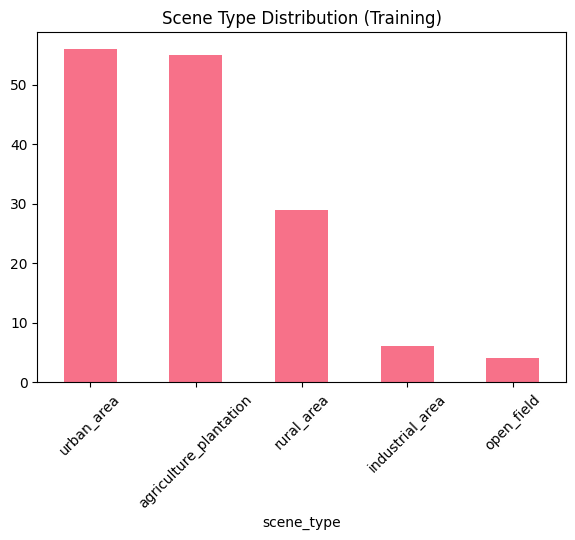

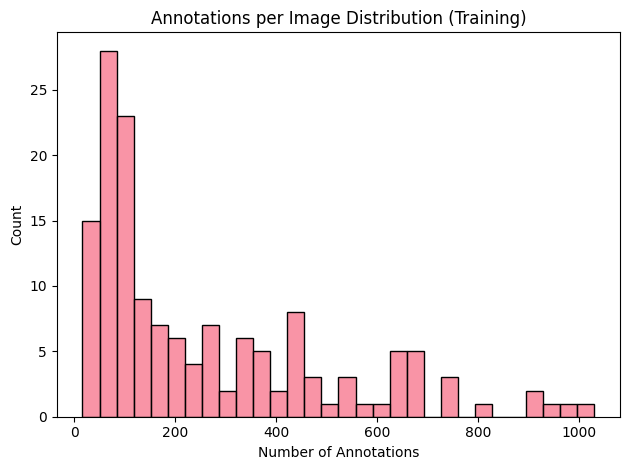

In [21]:
# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Scene Type Distribution
plt.subplot(2, 2, 1)
train_properties['scene_type'].value_counts().plot(kind='bar')
plt.title('Scene Type Distribution (Training)')
plt.xticks(rotation=45)
plt.show()

sns.histplot(data=train_properties, x='num_annotations', bins=30)
plt.title('Annotations per Image Distribution (Training)')
plt.xlabel('Number of Annotations')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [ ]:
from pathlib import Path
import re

def analyze_image_files(directory):
    # Get all .tif files
    image_files = list(Path(directory).glob('*.tif'))
    
    # Extract resolutions and counts
    resolution_pattern = re.compile(r'(\d+)cm')
    resolutions = {}
    
    for file in image_files:
        match = resolution_pattern.search(file.name)
        if match:
            res = int(match.group(1))
            resolutions[res] = resolutions.get(res, 0) + 1
    
    return {
        'total_images': len(image_files),
        'resolution_counts': resolutions,
        'total_size_mb': sum(file.stat().st_size / (1024 * 1024) for file in image_files)
    }

# Analyze both directories
train_stats = analyze_image_files('train_images')
eval_stats = analyze_image_files('evaluation_images')

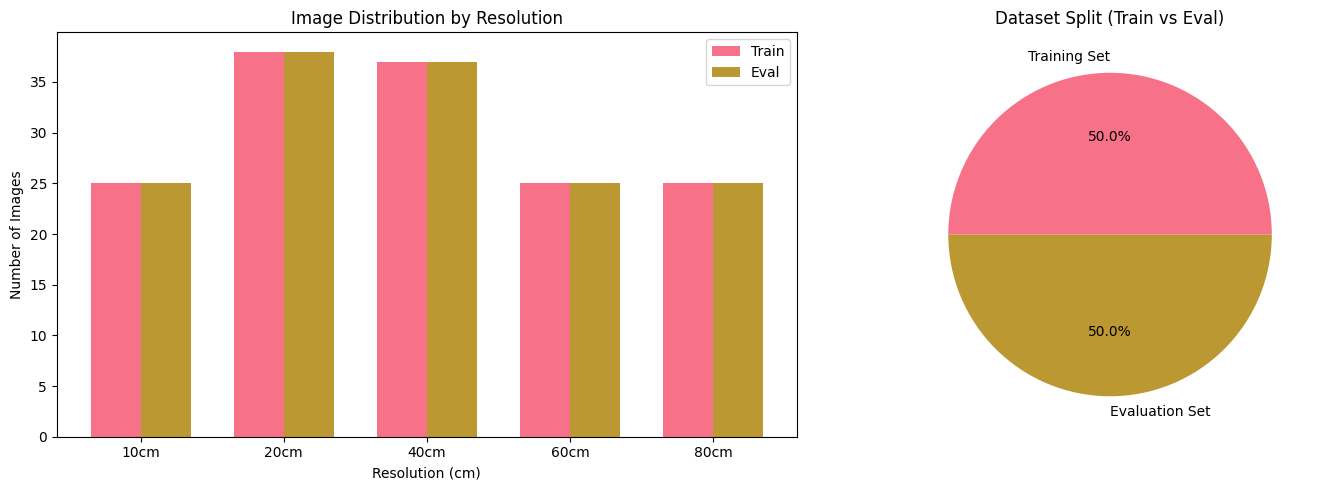

In [24]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x = np.arange(len(train_stats['resolution_counts']))
width = 0.35

plt.bar(x - width/2, train_stats['resolution_counts'].values(), width, label='Train')
plt.bar(x + width/2, eval_stats['resolution_counts'].values(), width, label='Eval')
plt.xlabel('Resolution (cm)')
plt.ylabel('Number of Images')
plt.title('Image Distribution by Resolution')
plt.xticks(x, [f"{res}cm" for res in sorted(train_stats['resolution_counts'].keys())])
plt.legend()

# Plot 2: Dataset Size Comparison
plt.subplot(1, 2, 2)
plt.pie([train_stats['total_images'], eval_stats['total_images']], 
        labels=['Training Set', 'Evaluation Set'],
        autopct='%1.1f%%')
plt.title('Dataset Split (Train vs Eval)')

plt.tight_layout()
plt.show()

In [ ]:
# Print comparison statistics
print("\nDataset Comparison:")
print(f"Training set: {train_stats['total_images']} images ({train_stats['total_size_mb']:.2f} MB)")
print(f"Evaluation set: {eval_stats['total_images']} images ({eval_stats['total_size_mb']:.2f} MB)")
print(f"Total dataset: {train_stats['total_images'] + eval_stats['total_images']} images "
      f"({train_stats['total_size_mb'] + eval_stats['total_size_mb']:.2f} MB)")

# Calculate and print resolution-wise split
print("\nResolution-wise Split:")
print(f"{'Resolution':<10} {'Train':<8} {'Eval':<8} {'Ratio':<8}")
print("-" * 35)
for res in sorted(train_stats['resolution_counts'].keys()):
    train_count = train_stats['resolution_counts'].get(res, 0)
    eval_count = eval_stats['resolution_counts'].get(res, 0)
    ratio = train_count / eval_count if eval_count > 0 else float('inf')
    print(f"{res:3d}cm      {train_count:<8d} {eval_count:<8d} {ratio:.2f}")



Dataset Comparison:
Training set: 150 images (450.04 MB)
Evaluation set: 150 images (450.04 MB)
Total dataset: 300 images (900.08 MB)

Resolution-wise Split:
Resolution Train    Eval     Ratio   
-----------------------------------
 10cm      37       38       0.97
 20cm      38       37       1.03
 40cm      25       25       1.00
 60cm      25       25       1.00
 80cm      25       25       1.00


## Converting To Dataset

## Running UNet

## Setting Up DINOV3/SAM2